In [14]:
import torch
from torch import nn

from torchsummary import summary

from models.coatnet import CoAtNet_3d
from models.transf import Model

from tqdm import tqdm
from config import CONFIG_BIG as CONFIG

from dataset_eval import AshbyDataset
from utils import seed_everything
seed_everything(42)
import matplotlib.pyplot as plt

In [2]:
c = 102 # 102
t, z, h, w = CONFIG['tubelet_dim']
emb_dim = 256 # 512
dims = [16, 32, 64, 128, emb_dim, 128, 64, 32, 16]
blocks = [2, 2, 3, 4, 5, 4, 3, 2, 2]
MODEL_SIZE =  (48, 160, 176)
ORIG_SIZE = (39, 157, 167)

bn_model = CoAtNet_3d((c, 48, 160, 176), dims, blocks)
bn_model.load_state_dict({k[:]:v for k,v in torch.load("saves/model_20_5vlhkqtm.pt").items()})

dims2 = [16, 32, 64, 128, emb_dim, 128, 32, 16, 8]
bn_model_dec = CoAtNet_3d((c, 48, 160, 176), dims2, blocks, num_classes=1)

bn_model.encoder.requires_grad = False # freeze encoder
encoder = nn.Sequential(
    bn_model.encoder
)
#  img_size, dims, blocks, tok_dim, heads, encoder_layers, bn_model, 
model = Model((c, t,) + MODEL_SIZE, 
        dims,
        blocks,
        tok_dim=512,
        heads=4,
        encoder_layers=4,
        bn_model=bn_model_dec)
bn_dim = model.bn_dim

(256, 3, 5, 6) 256
BN2Tok: 131,584
Transformer: 8,411,136
Tok2BN: 11,819,520
Decoder: 5,164,988


/home/weustis/.conda/envs/weustis2/lib/python3.8/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [ ]:
model.load_state_dict(torch.load("saves/model_80_1zj0727i.pt"))

In [3]:
dataset = AshbyDataset(None,time_as_batch=False, slice_dims=CONFIG['tubelet_dim'], padding=CONFIG['tubelet_pad'], context='middle')
test_dataset= dataset 

Normalizing
Done Normalizing
Converting Dataset into Padded Tensor
Found the following number of positions for (T,Z,H,W) 3 1 1 1


In [4]:
model = model.eval()
l2 = torch.nn.MSELoss()
l1 = torch.nn.L1Loss()

In [34]:
 # BTCZHW
with torch.no_grad():
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'], pin_memory=True, prefetch_factor=1)
    x, y = next(iter(dataloader))
    b, c, t, z, h, w = x.shape
    y = y.cuda()
    x = x.permute([0,2,1,3,4,5])
    x = x.view(b*t, c, z, h, w) 
    x = x.cuda(1)
    x = nn.functional.interpolate(x, size=MODEL_SIZE, mode='trilinear', align_corners=True)
    x = x.cuda(0)
    x = encoder(x)

            # b*t, C, 1, 1, 1
            # b, t, c, z, h, w
    x = x.view(b,t,-1)

            # b, t, E
    pred = model(x)
            # b c z h w
           # pred = torch.mean(pred, dim=1)  # mean across the T (View) dimension
            #pred = pred[:, :, :39, :157, :167]
    x = x.cuda(2)
    pred = nn.functional.interpolate(pred, size=ORIG_SIZE, mode='trilinear', align_corners=True)
    l2_loss = l2(pred, y.cuda())
    l1_loss = l1(pred, y.cuda())

In [35]:
print("L2:", l2_loss.item(), "\nL1:", l1_loss.item())

L2: 2.5321977138519287 
L1: 0.8774814009666443


In [36]:
l2_loss_0 = l2(torch.zeros_like(y), y)
l1_loss_0 = l1(torch.zeros_like(y), y)
print("L2:", l2_loss.item(), "\nL1:", l1_loss.item())

L2: 2.5321977138519287 
L1: 0.8774814009666443


In [37]:
pred.shape

torch.Size([1, 10, 39, 157, 167])

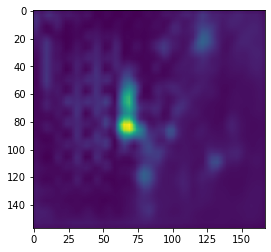

In [39]:
tmp = pred.permute([0, 2,3,4,1])[0]
plt.imshow(tmp[0, :, :, [0]].cpu())

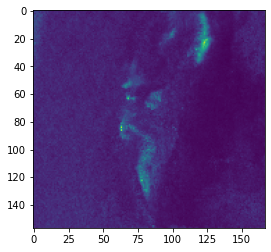

In [40]:
tmp2 = y.permute([0, 2,3,4,1])[0]
plt.imshow(tmp2[0, :, :, [0]].cpu())

In [6]:
dataset2 = AshbyDataset(None,time_as_batch=True, slice_dims=CONFIG['tubelet_dim'], padding=CONFIG['tubelet_pad'], context='middle')


Normalizing
Done Normalizing
Converting Dataset into Padded Tensor
Found the following number of positions for (T,Z,H,W) 133 1 1 1


In [8]:
bn_model = bn_model.cuda(2)

In [10]:
 # BTCZHW
with torch.no_grad():
    dataloader = torch.utils.data.DataLoader(dataset2, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'], pin_memory=True, prefetch_factor=1)
    x, y = next(iter(dataloader))
    b, c, z, h, w = x.shape

    x = x.cuda(1)
    x = nn.functional.interpolate(x, size=MODEL_SIZE, mode='trilinear', align_corners=True)
    x = x.cuda(2)

    print(x.shape)
    pred = bn_model(x)
            # b c z h w
           # pred = torch.mean(pred, dim=1)  # mean across the T (View) dimension
            #pred = pred[:, :, :39, :157, :167]
    x = x.cuda(1)
    pred = nn.functional.interpolate(pred, size=ORIG_SIZE, mode='trilinear', align_corners=True)
    
    y = y.cuda(2)
    l2_loss = l2(pred, y.cuda(2))
    l1_loss = l1(pred, y.cuda(2))

torch.Size([1, 102, 48, 160, 176])


In [11]:
print("L2:", l2_loss.item(), "\nL1:", l1_loss.item())

L2: 1.7639238834381104 
L1: 0.8331742286682129


In [12]:
l2_loss_0 = l2(torch.zeros_like(y), y)
l1_loss_0 = l1(torch.zeros_like(y), y)
print("L2:", l2_loss_0.item(), "\nL1:", l1_loss_0.item())

L2: 0.903073251247406 
L1: 0.6354615688323975


In [1]:
tmp = pred.permute([0, 2,3,4,1])[0]
plt.imshow(tmp[0, :, :, 0].cpu())
plt.colorbar()

NameError: name 'pred' is not defined

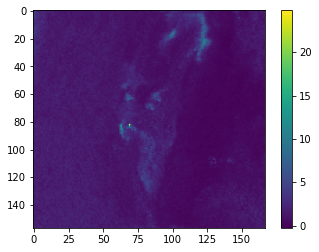

In [17]:
tmp2 = y.permute([0, 2,3,4,1])[0]
plt.imshow(tmp2[0, :, :, 0].cpu())
plt.colorbar()

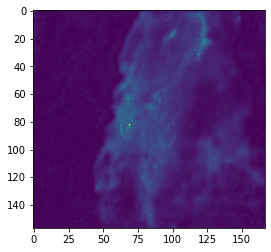

In [62]:
plt.imshow(torch.abs(tmp[0, :, :, 0] - tmp2[0, :, :, 0]).cpu())